In [1]:
from skimage.io import imread, imsave
import numpy as np
from skimage.filters import gaussian
import matplotlib.pyplot as plt

In [63]:
fname = '10x_1.0x_pAAA_TiTweez_1_MMStack_Pos0.ome.tif'
im_all = imread(fname)
im_all = im_all.transpose([0,2,3,1])
im_all = im_all[:,:,:,1:]
nt,nx,ny,nc = im_all.shape
bg = np.zeros((nc,))
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean()

<tifffile.TiffFile '10x_1.0x_pAAA_Ti…ck_Pos0.ome.tif'> MMStack series is missing files. Returning subset (1, 216, 5, 1) of (13, 216, 5, 1)


In [64]:
edt = np.load('results/edt.npy')
edt = edt[:,:,:]


In [65]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
w = int(w//2) * 2
h = maxy - miny
h = int(h//2) * 2

print(w,h)
pad = 32

crop_im_all = np.zeros((nt,w+2*pad,h+2*pad,nc))
crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
print(crop_im_all.shape)
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    cim = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, :]
    crop_im_all[t,:,:,:] = cim
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]

464 446
(216, 528, 510, 4)
(216, 528, 510)


#### Registration with skimage

In [66]:
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform, warp
for t in range(1,nt):
    shift,err,phase = phase_cross_correlation(crop_im_all[0,:,:,0].astype(float), crop_im_all[t,:,:,0].astype(float))
    tform = EuclideanTransform(translation=[shift[1],shift[0]])
    for c in range(nc):
        crop_im_all[t,:,:,c] = warp(crop_im_all[t,:,:,c], tform.inverse)
    crop_edt[t,:,:] = warp(crop_edt[t,:,:], tform.inverse)

In [67]:
im_all = crop_im_all
edt = crop_edt
del crop_im_all
del crop_edt

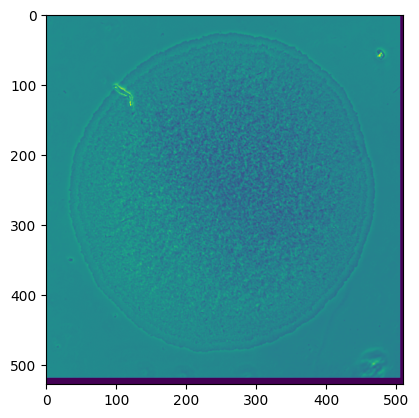

In [68]:
plt.imshow(im_all[-1,:,:,0])

In [69]:
nt,nx,ny,nc = im_all.shape

normed_im = np.zeros((nt,nx,ny,nc))
for t in range(nt):
    tedt = edt[t,:,:]
    for c in range(nc):
        tcim = im_all[t,:,:,c]
        mean_tcim = tcim[tedt>0].mean()
        std_tcim = tcim[tedt>0].std()
        min_tcim = tcim[tedt>0].min()
        max_tcim = tcim[tedt>0].max()
        #ntcim = (tcim - mean_tcim)/std_tcim
        ntcim = (tcim - min_tcim) / (max_tcim - min_tcim)
        if c>0:
            # Remove fluo from bg
            ntcim[tedt==0] = 0 # np.nan
        normed_im[t,:,:,c] = ntcim

#vmin = np.nanmin(normed_im)
#vmax = np.nanmax(normed_im)
#for t in range(nt):
#    plt.figure(figsize=(12,12))
    #for c in range(nc):
    #    plt.subplot(1, 3, c + 1)
    #    plt.imshow(normed_im[t,:,:,c], vmin=vmin, vmax=vmax)
    #    plt.colorbar()
    #    plt.xticks([])
    #    plt.yticks([])
#    plt.imshow(normed_im[t,:,:,0])
#    plt.imshow(normed_im[t,:,:,1:])
#    plt.xticks([])
#    plt.yticks([])
#    plt.tight_layout()
#    plt.savefig('normed_channels_%04d.png'%t)
#    plt.close()

In [70]:
#normed_im[:,:,:,0] = im_all[:,:,:,0]
imsave('normed_im.tif', normed_im[:,:,:,[1,2,3,0]])

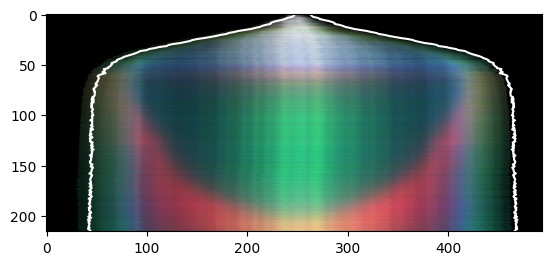

In [12]:
cx = nx // 2
cy = ny // 2
plt.imshow(normed_im[:,cx-16:cx+16,:,1:].mean(axis=1))
radius = edt.max(axis=(1,2))
plt.plot(cx + radius, np.arange(nt), 'w')
plt.plot(cx - radius, np.arange(nt), 'w')

In [9]:
nt,nx,ny,nc = im_all.shape
nr = 64
rw = 16
rs = np.linspace(rw, edt.max(), nr)
kymo = np.zeros((nt,nr,3)) + np.nan
nkymo = np.zeros((nt,nr,3)) + np.nan
for t in range(nt):
    for c in range(3):
        for ri in range(nr):
            tedt = edt[t,:,:]
            idx = np.abs(tedt - rs[ri]) < rw
            if np.sum(idx)>0:
                ntcim = im_all[t,:,:,1+c]
                kymo[t,ri,c] = np.nanmean(ntcim[idx])
                ntcnim = normed_im[t,:,:,1+c]
                nkymo[t,ri,c] = np.nanmean(ntcnim[idx])
                

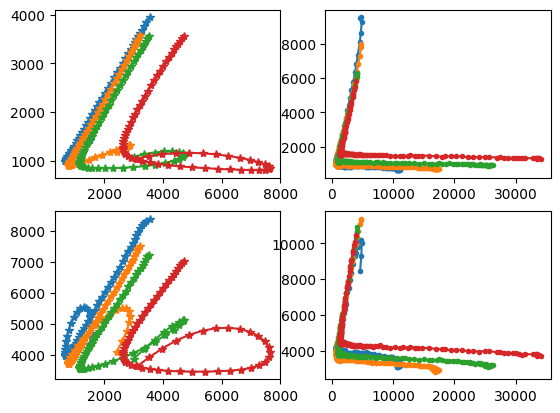

In [7]:
plt.subplot(2,2,1)
plt.plot(kymo[[75,100,125,150],:,0].transpose(), kymo[[75,100,125,150],:,1].transpose(), '*-')
plt.subplot(2,2,2)
plt.plot(kymo[:,[15,23,31,39],0], kymo[:,[15,23,31,39],1], '.-')
plt.subplot(2,2,3)
plt.plot(kymo[[75,100,125,150],:,0].transpose(), kymo[[75,100,125,150],:,2].transpose(), '*-')
plt.subplot(2,2,4)
plt.plot(kymo[:,[15,23,31,39],0], kymo[:,[15,23,31,39],2], '.-')

In [10]:
nr = 64
rw = 8
rs = np.linspace(rw, edt.max(), nr)

cov = np.zeros((nt,nr,3,3))
corr = np.zeros((nt,nr,3))
mean = np.zeros((nt,nr,3))
for t in range(nt):
    for ri in range(nr):
        tedt = edt[t,:,:]
        idx = np.abs(tedt - rs[ri]) < rw
        if np.sum(idx)>0:
            #plt.figure()
            ntim0 = im_all[t,:,:,1].astype(float) - bg[1]
            ntim1 = im_all[t,:,:,2].astype(float) - bg[2]
            ntim2 = im_all[t,:,:,3].astype(float) - bg[3]
            x,y,z = ntim0[idx], ntim1[idx], ntim2[idx]
            C = np.cov(np.stack([x, y, z]))
            cov[t,ri,:,:] = C
            corr[t,ri,0] = np.corrcoef(x, y)[0,1]
            corr[t,ri,1] = np.corrcoef(x, z)[0,1]
            corr[t,ri,2] = np.corrcoef(y, z)[0,1]
            mean[t,ri,0] = x.mean()
            mean[t,ri,1] = y.mean()
            mean[t,ri,2] = z.mean()

/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_81137/1796540011.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice
  C = np.cov(np.stack([x, y, z]))
/Users/timrudge/opt/anaconda3/envs/infotracking/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/timrudge/opt/anaconda3/envs/infotracking/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/timrudge/opt/anaconda3/envs/infotracking/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


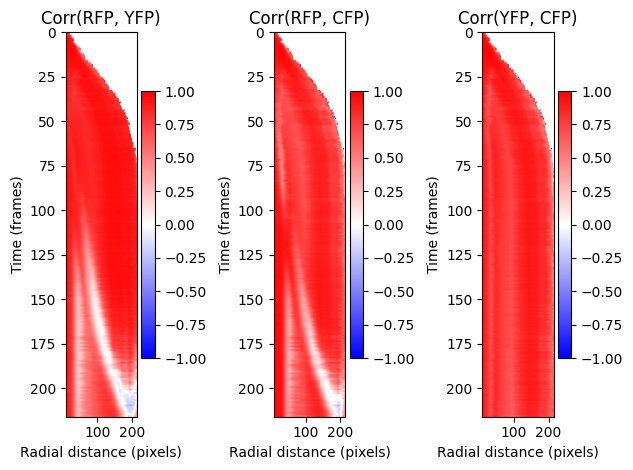

In [11]:
t0 = 0

plt.subplot(1,3,1)
plt.imshow(corr[t0:,:,0], extent=[rw,edt.max(),nt,0], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Corr(RFP, YFP)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(corr[t0:,:,1], extent=[rw,edt.max(),nt,0], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Corr(RFP, CFP)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(corr[t0:,:,2], extent=[rw,edt.max(),nt,0], aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Corr(YFP, CFP)')
plt.colorbar()

plt.tight_layout()

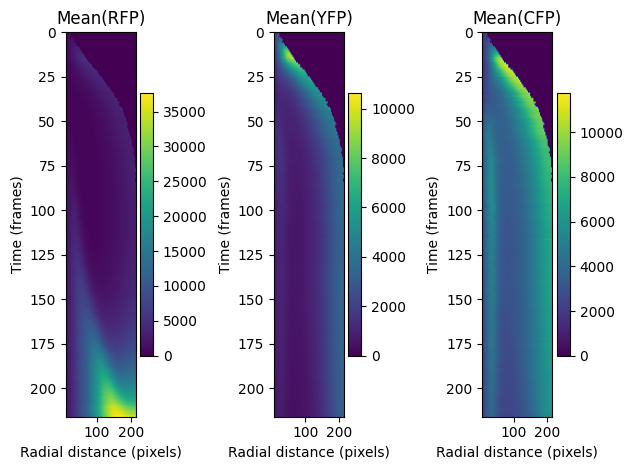

In [63]:
t0 = 0

plt.subplot(1,3,1)
plt.imshow(mean[t0:,:,0], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(RFP)')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(mean[t0:,:,1], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(YFP)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(mean[t0:,:,2], extent=[rw,edt.max(),nt,0], aspect='auto')
plt.ylabel('Time (frames)')
plt.xlabel('Radial distance (pixels)')
plt.title('Mean(CFP)')
plt.colorbar()

plt.tight_layout()

In [59]:
from  scipy.signal import savgol_filter
ngamma = 1
gammas = [np.log(2)/(6*60/10)] #np.linspace(1e-4, 1e-1, ngamma)
varW = np.zeros((nt,ngamma,2))
covW = np.zeros((nt,ngamma))
for ri in [32]: # range(nr):
    for g in range(ngamma):
        gamma = gammas[g]
        svar = savgol_filter(var[:,g,:], 31, 3, axis=0)
        dsvar = savgol_filter(var[:,g,:], 31, 3, axis=0, deriv=1)
        scov = savgol_filter(cov[:,g], 31, 3, axis=0)
        dscov = savgol_filter(cov[:,g], 31, 3, axis=0, deriv=1)
        varW[:,g,:] = dsvar + 2 * gamma * svar
        covW[:,g] = dscov + 2 * gamma * scov
        corr[:,g] = covW[:,g] / np.sqrt(varW[:,g,0] * varW[:,g,1])


/var/folders/k8/h6brl0ns6vz0_mrl3gdnlzj00000gn/T/ipykernel_27179/1361725257.py:15: RuntimeWarning: invalid value encountered in divide
  corr[:,g] = covW[:,g] / np.sqrt(varW[:,g,0] * varW[:,g,1])


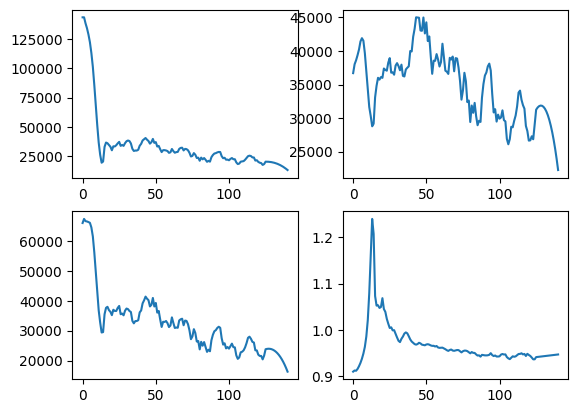

In [60]:
plt.subplot(2,2,1)
plt.plot(varW[75:,:,0])
#plt.colorbar()
plt.subplot(2,2,2)
plt.plot(varW[75:,:,1])
#plt.colorbar()
plt.subplot(2,2,3)
plt.plot(covW[75:,:])
#plt.colorbar()
plt.subplot(2,2,4)
plt.plot(covW[75:,:] / np.sqrt(varW[75:,:,0]) / np.sqrt(varW[75:,:,1]))
#plt.ylim([-1,1])
#plt.colorbar()

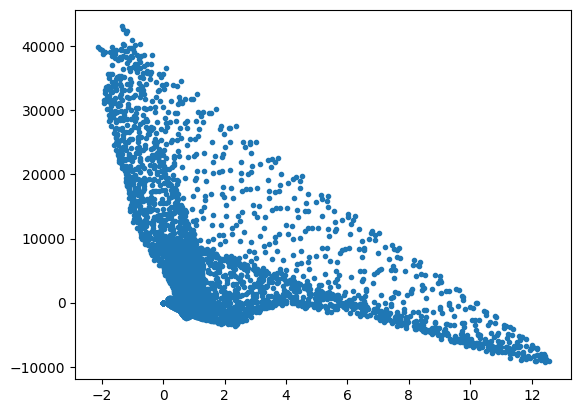

In [12]:
plt.plot(pp[:,:,0].ravel(), pp[:,:,1].ravel(), '.')

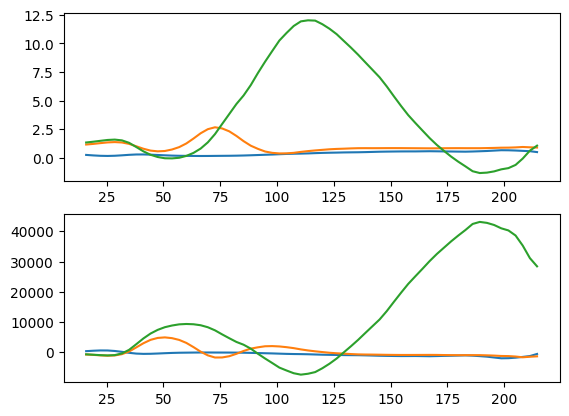

In [18]:
plt.subplot(2,1,1)
plt.plot(rs, pp[[75,150,215],:,0].transpose())
plt.subplot(2,1,2)
plt.plot(rs, pp[[75,150,215],:,1].transpose())

0.9807534625350182
1722.9207672428033
0.9845147763486481
1546.6816252048216


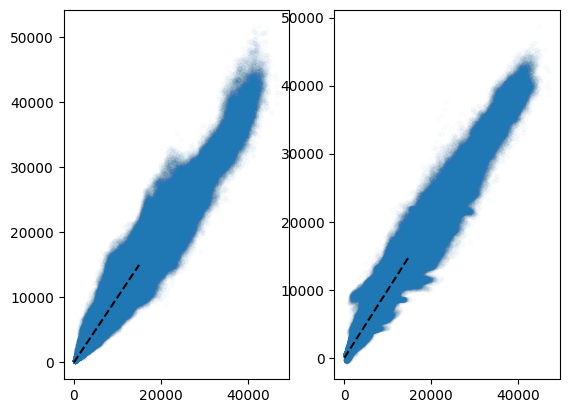

In [253]:
plt.subplot(1,2,1)
plt.plot(true, model1, '.', alpha=0.01)
print(np.corrcoef(true, model1)[0,1])
print(np.sqrt(np.mean((model1-true)**2)))
plt.plot([0,15000], [0,15000], 'k--')
plt.subplot(1,2,2)
plt.plot(true, model2, '.', alpha=0.01)
print(np.corrcoef(true, model2)[0,1])
print(np.sqrt(np.mean((model2-true)**2)))
plt.plot([0,15000], [0,15000], 'k--')

In [8]:
def map_func(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

from skimage.transform import warp
wnkymo = np.zeros_like(nkymo)
for c in range(3):
    wnkymo[:,:,c] = warp(nkymo[:,:,c], map_func, {'edt':edt, 'rs':rs})
wnkymo[np.isnan(nkymo)] = np.nan

(216, 64, 3)


Text(0.5, 1.0, 'Normalized fluorescence')

/Users/timrudge/opt/anaconda3/envs/infotracking/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


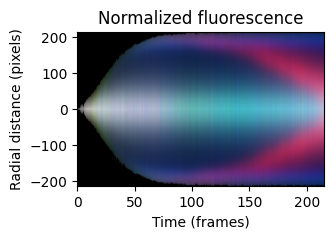

In [9]:
print(wnkymo.shape)
plt.figure(figsize=(7,2))
plt.subplot(1, 2, 1)
plt.imshow(np.hstack([wnkymo[:,::-1,:],wnkymo[:,:,:]]).transpose([1,0,2]), 
           aspect='auto', 
           extent=[0,215,-edt.max(),edt.max()])
plt.xlabel('Time (frames)')
plt.ylabel('Radial distance (pixels)')
plt.title('Normalized fluorescence')

(216, 64, 2)


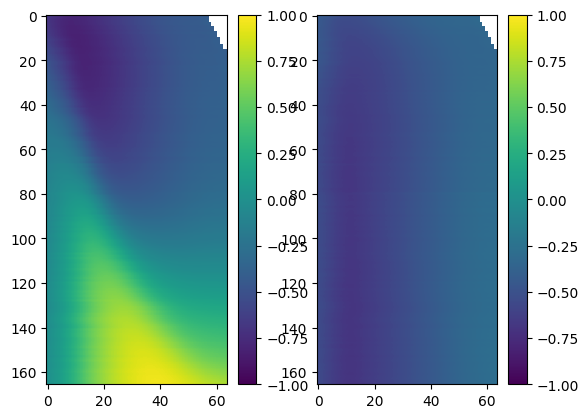

In [10]:
from scipy.signal import savgol_filter
kymo_rho = np.stack([kymo[:,:,0] / kymo[:,:,2], kymo[:,:,1] / kymo[:,:,2]], axis=2)
print(kymo_rho.shape)
lkymo_rho = np.log(kymo_rho)
dlkymo_rho = np.zeros_like(lkymo_rho) + np.nan
for r in range(nr):
    for c in range(2):
        idx = ~np.isnan(lkymo_rho[:,r,c])
        dlkymo_rho[idx,r,c] = savgol_filter(lkymo_rho[idx,r,c], 21, 3, deriv=1, axis=0)
plt.subplot(1, 2, 1)
plt.imshow(np.log10(kymo_rho[50:,:,0]), vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.log10(kymo_rho[50:,:,1]), vmin=-1, vmax=1, aspect='auto')
plt.colorbar()

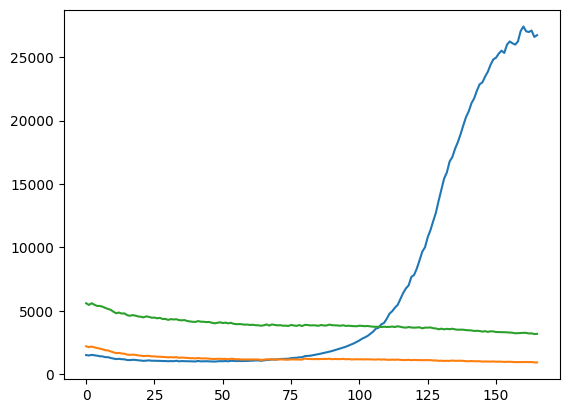

In [86]:
plt.plot(kymo[50:,32,:])

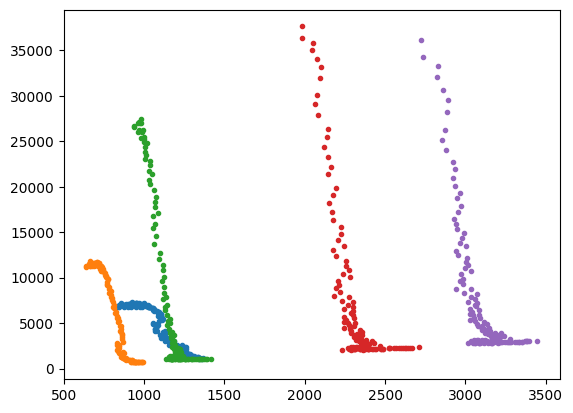

In [185]:
for ri in [8,16,32,48,56]:
    x,y = kymo[75:,ri,1], kymo[75:,ri,0]
    plt.plot(x, y, '.')

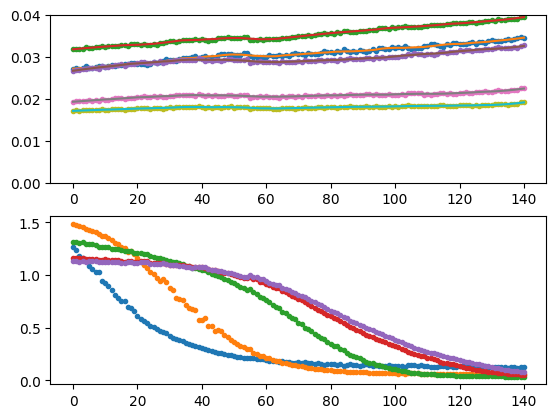

In [184]:
for ri in [8,16,32,48,56]:
    x,y = 1/np.sqrt(kymo[75:,ri,1]), kymo[75:,ri,0] / kymo[75:,ri,1]
    sx,sy = savgol_filter(x, 21, 3, deriv=1), savgol_filter(y, 21, 3, deriv=1)
    plt.subplot(2, 1, 1)
    plt.plot(x, '.')
    plt.ylim([0,0.04])
    #plt.plot(sx, '-')
    plt.plot(savgol_filter(x, 21, 3), '-')
    plt.subplot(2, 1, 2)
    plt.plot(1 / y, '.')
    #plt.plot(sy, '-')


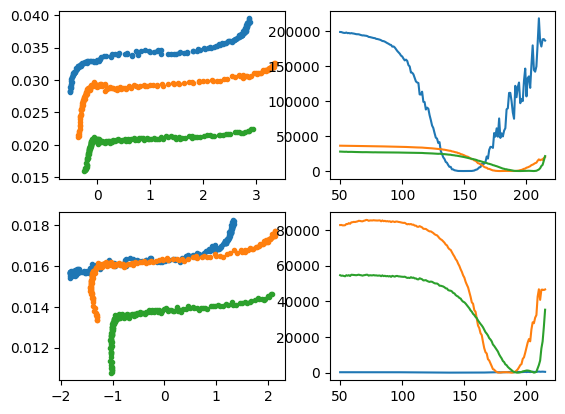

In [163]:
from scipy.interpolate import UnivariateSpline

ris = [16,32,48]
t0 = 50

for ri in ris:
    plt.subplot(2, 2, 1)
    y,x = 1/np.sqrt(kymo[t0:,ri,1]), kymo[t0:,ri,0] / kymo[t0:,ri,1]
    plt.plot(np.log(x), y, '.')

    t = np.arange(t0, nt)

    idx = np.argsort(x)
    #plt.legend(ris)
    s = UnivariateSpline(x[idx], y[idx], s=len(x)*0.01)
    xx = np.linspace(x.min(), x.max(), 100)
    #plt.plot(xx, s(xx))

    #num_bins = 16
    #hist, bin_edges = np.histogram(x, bins=num_bins)
    #bin_indices = np.digitize(x, bin_edges) - 1
    #bin_indices[bin_indices == num_bins] = num_bins - 1
    #bin_means = np.array([y[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
    #s = UnivariateSpline(bin_edges[:-1], bin_means, s=0.1)
    #xx = np.linspace(x.min(), x.max(), 100)
    #plt.plot(xx, s(xx))

    plt.subplot(2, 2, 2)
    y = s.derivative(1)(x)**2
    y = y / y.min()
    #plt.plot(t[idx], y, '.')
    #y = savgol_filter(bin_means, 11, 3, deriv=1)
    plt.plot(t, y)

    plt.subplot(2, 2, 3)
    y,x = 1/np.sqrt(kymo[t0:,ri,2]), kymo[t0:,ri,0] / kymo[t0:,ri,2]
    plt.plot(np.log(x), y, '.')
    #plt.legend(ris)

    idx = np.argsort(x)
    #plt.legend(ris)
    s = UnivariateSpline(x[idx], y[idx], s=len(x)*0.01)
    xx = np.linspace(x.min(), x.max(), 100)
    #plt.plot(xx, s(xx))

    #num_bins = 24
    #hist, bin_edges = np.histogram(x, bins=num_bins)
    #bin_indices = np.digitize(x, bin_edges) - 1
    #bin_indices[bin_indices == num_bins] = num_bins - 1
    #bin_means = np.array([y[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan for i in range(num_bins)])
    #s = UnivariateSpline(bin_edges[:-1], bin_means, s=0.1)
    #plt.plot(x, s(x))

    plt.subplot(2, 2, 4)
    y = s.derivative(1)(x)**2
    y = y / y.min()
    #plt.plot(t[idx], y, '.')
    #y = savgol_filter(bin_means, 11, 3, deriv=1)
    plt.plot(t, y)

    
    

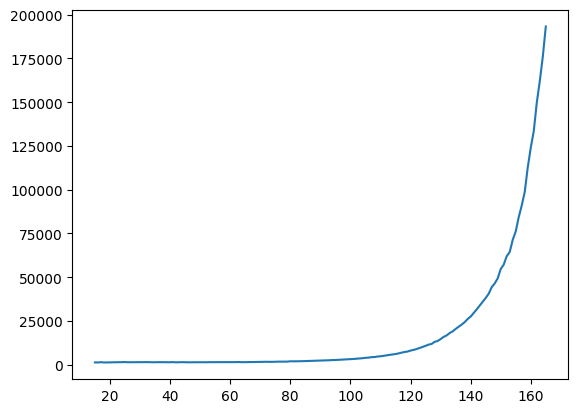

In [56]:
plt.plot(kymo[50:,-1,0] * kymo_rho[50:,-1,0])

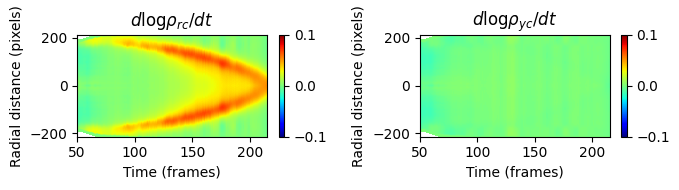

In [9]:
def map_func(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

from skimage.transform import warp
wdlkymo_rho = np.zeros_like(dlkymo_rho)
for c in range(2):
    wdlkymo_rho[:,:,c] = warp(dlkymo_rho[:,:,c], map_func, {'edt':edt, 'rs':rs})
wdlkymo_rho[np.isnan(dlkymo_rho)] = np.nan

plt.figure(figsize=(7,2))
plt.subplot(1, 2, 1)
plt.imshow(np.hstack([wdlkymo_rho[50:,::-1,0],wdlkymo_rho[50:,:,0]]).transpose(), 
           aspect='auto', 
           extent=[50,215,-edt.max(),edt.max()],
           vmin=-0.1, vmax=0.1,
           cmap='jet')
plt.colorbar()
plt.xlabel('Time (frames)')
plt.ylabel('Radial distance (pixels)')
plt.title('$d\mathrm{log}\\rho_{rc}/dt$')

plt.subplot(1, 2, 2)
plt.imshow(np.hstack([wdlkymo_rho[50:,::-1,1],wdlkymo_rho[50:,:,1]]).transpose(), 
           aspect='auto', 
           extent=[50,215,-edt.max(),edt.max()],
           vmin=-0.1, vmax=0.1,
           cmap='jet')
plt.colorbar()
plt.xlabel('Time (frames)')
plt.ylabel('Radial distance (pixels)')
plt.title('$d\mathrm{log}\\rho_{yc}/dt$')

plt.tight_layout()
plt.savefig('wdlkymo_rho.png', dpi=300)


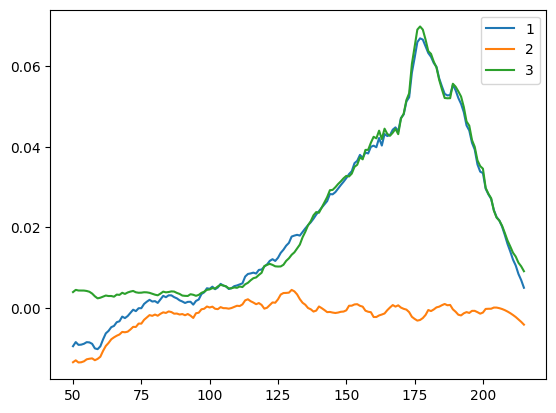

In [10]:
plt.plot(np.arange(50, 216), wdlkymo_rho[50:,24,:])
plt.plot(np.arange(50, 216), wdlkymo_rho[50:,24,0] - wdlkymo_rho[50:,24,1])
#plt.legend(rs[np.arange(20,28)])
plt.legend([1,2,3])

array([[143., 163., 249.],
       [192., 171., 229.],
       [192., 176., 202.]])

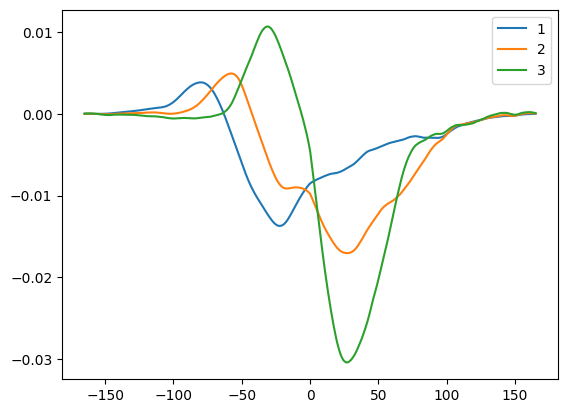

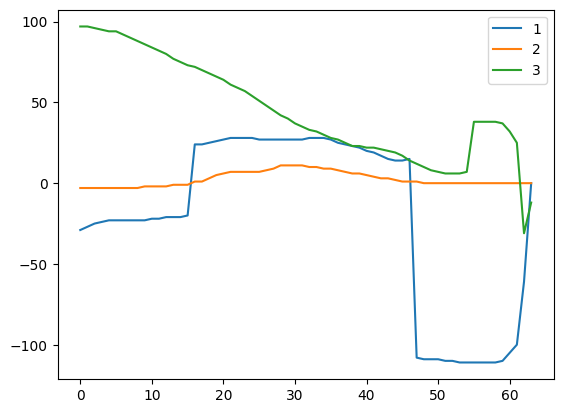

In [72]:
from scipy.signal import correlate, correlation_lags
cc = np.zeros((331,nr,3))
peaks = np.zeros((nr,3))
for r in range(nr):
    cc[:,r,0] = correlate(wdlkymo_rho[50:,r,0], wdlkymo_rho[50:,r,1], 'full')
    peaks[r,0] = np.argmin(cc[:,r,0])
    cc[:,r,1] = correlate(wdlkymo_rho[50:,r,0], wdlkymo_rho[50:,r,1] - wdlkymo_rho[50:,r,0], 'full')
    peaks[r,1] = np.argmin(cc[:,r,1])
    cc[:,r,2] = correlate(wdlkymo_rho[50:,r,1], wdlkymo_rho[50:,r,1] - wdlkymo_rho[50:,r,0], 'full')
    peaks[r,2] = np.argmin(cc[:,r,2])
#plt.imshow(cc[:,:,0])
nnt = wdlkymo_rho.shape[0] - 50
lags = correlation_lags(nnt, nnt)

plt.figure()
plt.plot(lags, cc[:,10,0])
plt.plot(lags, cc[:,20,0])
plt.plot(lags, cc[:,30,0])
plt.legend([1,2,3])

plt.figure()
plt.plot(lags[peaks.astype(int)])
plt.legend([1,2,3])

peaks[[10,20,30]]

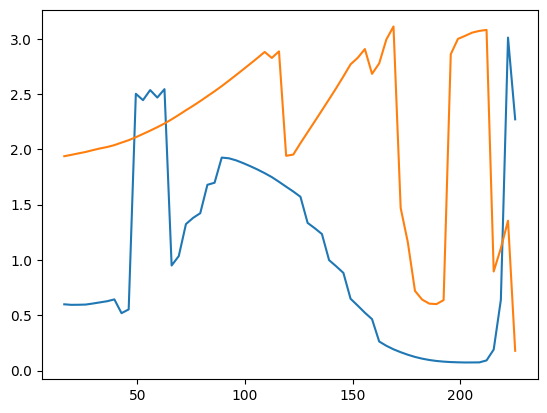

In [106]:
from numpy.fft import fft, fftshift, fftfreq

Ts = np.zeros((nr,2))
phases = np.zeros((nr,2))
for r in range(nr):
    for c in range(2):
        s = wdlkymo_rho[50:,r,c]
        ft = fft(s - s.mean(), len(s)*16)
        ps = (ft * ft.conjugate()).real
        freqs = fftfreq(len(ft))
        idx = (freqs<0.05) * (freqs>0)
        #plt.plot(freqs[idx], ps[idx], '.')

        pkidx = np.argmax(ps)
        f0 = freqs[pkidx]
        T = abs(1/f0)
        Ts[r,c] = T

        phase = np.angle(ft[pkidx])
        #if phase<0:
        #    phase = np.pi + phase
        phases[r,c] = abs(phase)
plt.plot(rs, phases)

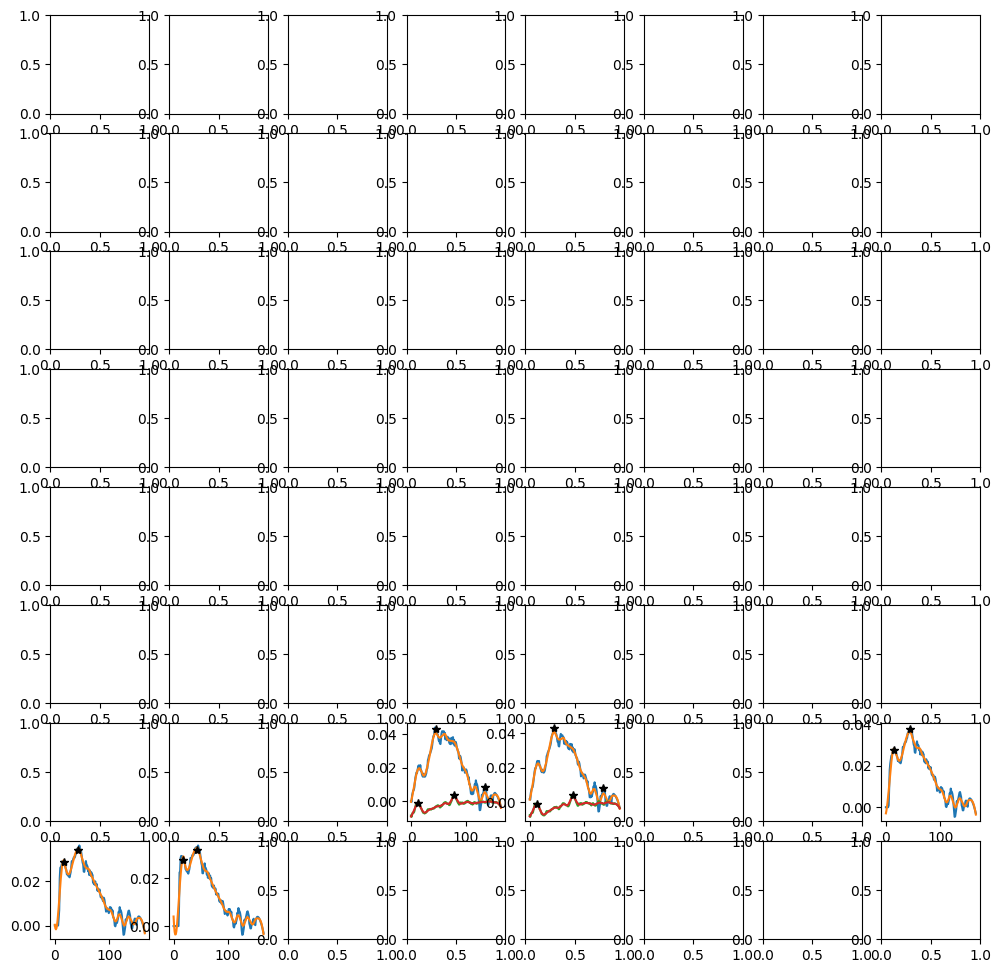

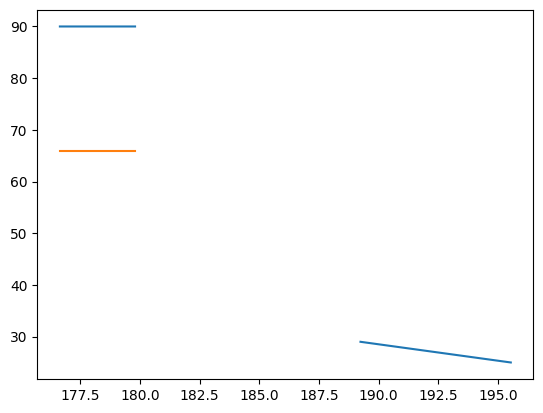

In [11]:
from scipy.signal import find_peaks

plt.figure(figsize=(12,12))
Ts = np.zeros((nr,2)) + np.nan
for r in range(nr):
    plt.subplot(8,8,r+1)
    for c in range(2):
        s = wdlkymo_rho[50:,r,c]
        ss = savgol_filter(s, 21, 3)
        pks = find_peaks(ss, prominence=0.005)[0]
        if len(pks)>1:
            T = np.mean(np.diff(pks))
            Ts[r,c] = T
            plt.plot(s)
            plt.plot(ss)
            plt.plot(pks, s[pks], 'k*')

plt.figure()
plt.plot(rs, Ts)

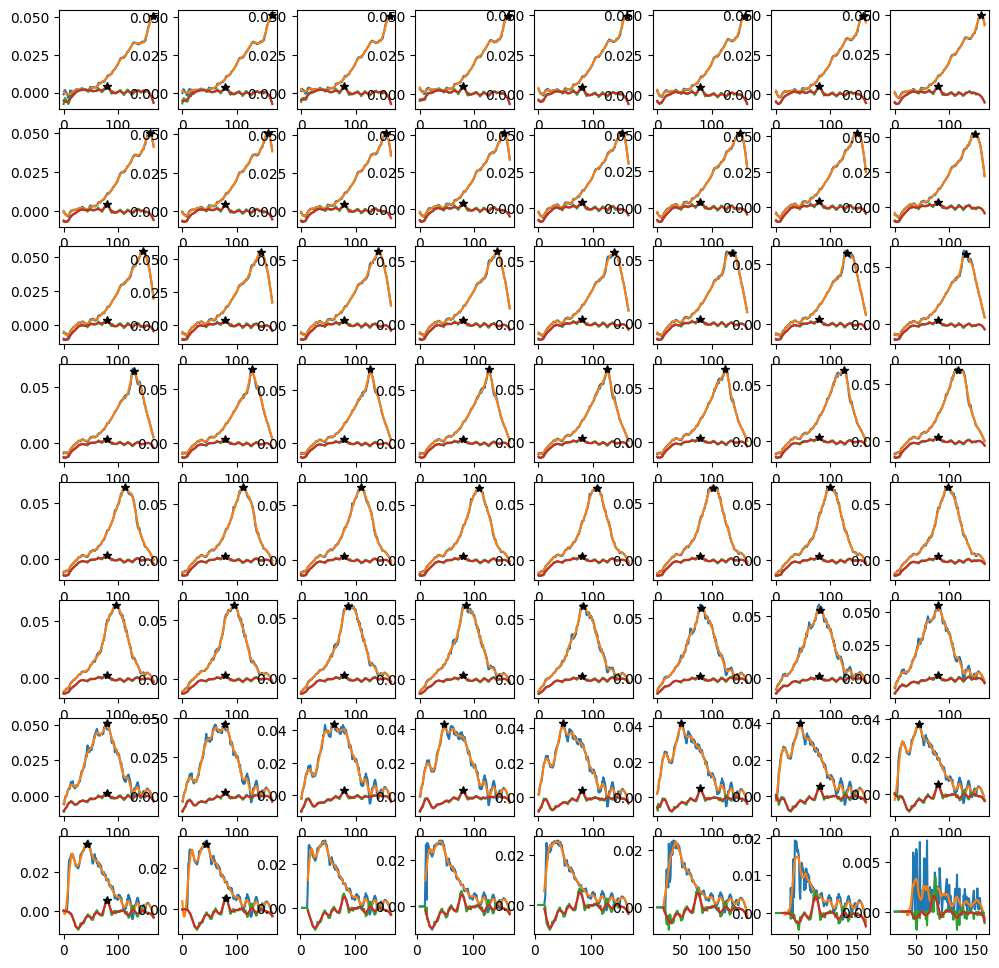

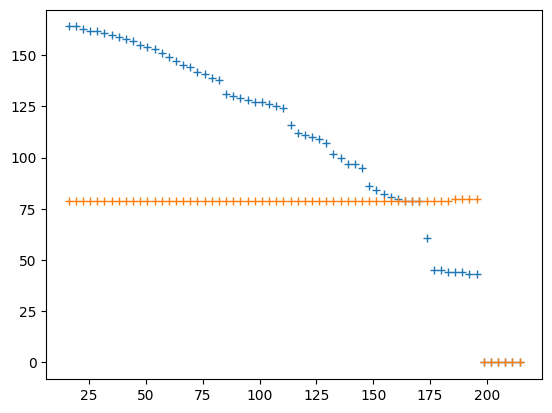

In [13]:
plt.figure(figsize=(12,12))
Ts = np.zeros((nr,2)) + np.nan
for r in range(nr):
    plt.subplot(8,8,r+1)
    for c in range(2):
        s = wdlkymo_rho[50:,r,c]
        ss = savgol_filter(s, 21, 3)
        T = np.argmax(ss)
        Ts[r,c] = T
        plt.plot(s)
        plt.plot(ss)
        plt.plot(T, s[T], 'k*')

plt.figure()
plt.plot(rs, Ts, '+')

In [ ]:
cf = np.zeros((nt,3))
for t in range(nt):
    tedt = edt[t,:,:]
    for c in range(3):
        tcim = im_all[t,:,:,c+1]
        idx = tedt.max() - tedt < 16
        cf[t,c] = np.nanmean(tcim[idx])

In [ ]:
crho_rc = cf[:,0] / cf[:,2]
crho_yc = cf[:,1] / cf[:,2]
crho_ry = cf[:,0] / cf[:,1]

lcrho_rc = np.log(crho_rc)
lcrho_yc = np.log(crho_yc)
lcrho_ry = np.log(crho_ry)

dlcrho_rc = savgol_filter(lcrho_rc, 21, 3, deriv=1)
dlcrho_yc = savgol_filter(lcrho_yc, 21, 3, deriv=1)
dlcrho_ry = savgol_filter(lcrho_ry, 21, 3, deriv=1)

In [ ]:
plt.plot(dlcrho_rc)
plt.plot(dlcrho_yc)
plt.plot(dlcrho_ry)

In [ ]:
from scipy.integrate import odeint

alpha_r, alpha_c = 1,1
k_r, k_c = 1,1
p = 10
n = 1

ir,ic = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
drhodt = (alpha_r * k_r * ir - alpha_c * k_c * ic) * p**n / (1 + k_r * p**n + k_c * p**n)

In [ ]:
plt.imshow(drhodt)
plt.colorbar()